In [2]:
from sympy import *
init_printing()

In [7]:
R = Symbol("R", positive=True, real=True)
a, b = symbols("a b", real=True)
v = (a+b)/2
i = (a-b)/(2*R)

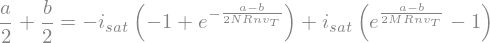

In [22]:
diode_expr = lambda isat, n, vt: lambda v: isat*(exp(v/(n*vt))-1)

def diode_eq(isat, n, vt, M, N):
    id = diode_expr(isat, n, vt)
    return lambda i, v: Eq(i, id(v/M) - id(-v/N))

isat, n, vt = symbols("i_sat n v_T", real=True, positive=True)
M, N = symbols("M N", integer=True, positive=True)
diode_eq(isat, n, vt, M, N)(v, i)

In [23]:
from attr import dataclass


@dataclass(frozen=True)
class NewtonRhapson:
    x: Symbol
    y: Symbol
    iteration: Expr
    jacobian: Expr
    inv_jacobian: Expr

    @classmethod
    def from_expr(cls, expr: Expr, x: Symbol, y: Symbol) -> "NewtonRhapson":
        j = diff(expr, y)
        j_inv = 1/j
        return cls(x, y, expr.simplify(), j.simplify(), j_inv.simplify())

    @classmethod
    def from_equality(cls, eq: Eq, x: Symbol, y: Symbol) -> "NewtonRhapson":
        return cls.from_expr(eq.rhs - eq.lhs, x, y)

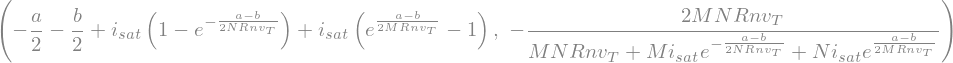

In [24]:
nr = NewtonRhapson.from_equality(diode_eq(isat, n, vt, M, N)(v, i), a, b)
nr.iteration, nr.inv_jacobian

In [25]:
def print_code(expr: Expr):
    vars, e = cse(expr.n())
    for name, expr in vars:
        yield rust_code(expr, name)
    yield rust_code(e)

print(*print_code(nr.iteration), sep="\n")

x0 = (1_f64/2.0)*(a - b)/(R*n*v_T);
[-0.5*a - 0.5*b + i_sat*(1.0 - (-x0/N).exp()) + i_sat*((x0/M).exp() - 1.0)]


In [26]:
print(*print_code(nr.inv_jacobian), sep="\n")

x0 = M*N*R*n*v_T;
x1 = (1_f64/2.0)*(a - b)/(R*n*v_T);
[-2.0*x0/(M*i_sat*(-x1/N).exp() + N*i_sat*(x1/M).exp() + x0)]
